In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime as dt
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter 

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

In [3]:
def plotCSNS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

## Import data

In [4]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [ ]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forpr_ros3','backadm_ros3','backvs_ros3','forpr_haro3','forgulf_haro3','backvs_haro3','backadm_haro3',
         'forvs_haro3','foradm_haro3','backpr_haro3','backgulf_haro3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2021,12,27)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass


In [6]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['foradm_haro3','forvs_haro3','backpr_haro3','backgulf_haro3','backadm_haro3','backvs_haro3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2021,12,27)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass


In [6]:
dict_secdata = {}
sectionnum = [0,1,2,3,4,5,6,7,8]

for file in files:
    
    if file not in dict_secdata:
        dict_secdata[file] = {}
    
    for section in sectionnum:
        
        if section not in dict_secdata[file]:
            
            dict_secdata[file][section] = {}
            
        for date in dicts[file].keys():
            
            if section not in dict_secdata[file]:
            
                dict_secdata[file][section][date] = {}
            
            dict_secdata[file][section][date] = get_secdata(dicts[file][date],section)

In [7]:
prtovs_haro_sal = []
prtovs_haro_temp = []

for date in dict_secdata['forpr_haro3'][4].keys():
    prtovs_haro_sal.append(np.mean(dict_secdata['forpr_haro3'][6][date]['final_salt'].values))
    prtovs_haro_temp.append(np.mean(dict_secdata['forpr_haro3'][6][date]['final_temp'].values))
    
vstopr_haro_sal = []
vstopr_haro_temp = []

for date in dict_secdata['forvs_haro3'][4].keys():
    vstopr_haro_sal.append(np.mean(dict_secdata['forvs_haro3'][6][date]['final_salt'].values))
    vstopr_haro_temp.append(np.mean(dict_secdata['forvs_haro3'][6][date]['final_temp'].values))
    
prtovs_ros_sal = []
prtovs_ros_temp = []

for date in dict_secdata['forpr_haro3'][4].keys():
    prtovs_ros_sal.append(np.mean(dict_secdata['forpr_ros3'][4][date]['final_salt'].values))
    prtovs_ros_temp.append(np.mean(dict_secdata['forpr_ros3'][4][date]['final_temp'].values))
    
prtovs_haro_salb = []
prtovs_haro_tempb = []

for date in dict_secdata['forpr_ros3'][4].keys():
    prtovs_haro_salb.append(np.mean(dict_secdata['backvs_haro3'][6][date]['final_salt'].values))
    prtovs_haro_tempb.append(np.mean(dict_secdata['backvs_haro3'][6][date]['final_temp'].values))

In [8]:
month_avg = np.zeros([12,len(sectransp_2018['forpr_ros3'].keys())])

for sectionnum in sectransp_2018['forpr_ros3'].keys():
    intermed = sectransp_2018['forpr_ros3'][sectionnum]
    for month in range(1,13):
        dates = [index for index, date in enumerate(datelist_vs) if date.month == month]
        selected_elements = [sectransp_2018['forpr_ros3'][sectionnum][index] for index in dates]
        month_avg[month-1,sectionnum] = np.mean(selected_elements)
    

In [9]:
dates = [index for index, date in enumerate(datelist_vs) if date.month == 1]
selected_elements = [sectransp_2018['forpr_ros3'][0][index] for index in dates]
date_jan = [datelist_vs for index in dates]

date = dt.datetime(2018,1,1)
enddate = dt.datetime(2019,1,1)

dates = []
datelist_yr = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_yr.append(date)
    date+=dt.timedelta(days=31)

### Shifting functions

In [28]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

### Import density data

In [29]:
# Importing density and tidal data

density_ros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2017-22_rosarioNS.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)

density_rosVS = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/sigma_2018_rosariopr_202111_meanv2.csv')
dens_diff_rosVS = np.array(density_rosVS.south - density_rosVS.north)

density_haro = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/sigma_2018_harovs_202111_mean_v2.csv')
dens_diff_haro = np.array(density_haro.south - density_haro.north)

density_vspr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2017-22_202111_mean.csv')
dens_diff_vspr = np.array(density_vspr.south - density_vspr.north)

tides = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/low_pass_tide_2018-22_BP.csv')
# tides = pd.read_csv('low_pass_tide_18-22.csv').iloc[:730,:]


date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.iloc[:,1].shape)   
 
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
dens_diff_ros
print(len(datelist_dens))
print(dens_diff_vspr.size)

2191
(2191,)
2191
2191


In [14]:
wind = pd.read_csv('../notebooks/day_avg_wind_17-22.csv')
x = wind['time']
y = wind['wind']

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_winds = []

while date <= enddate:
    datelist_winds.append(date)
    date+=dt.timedelta(days=1)
    
y_mean4 = y.rolling(window=4, center=True).mean()

#### Rosario to adm

In [15]:
PRtoadm_rosl = sectransp_2018['forpr_ros3'][2]
PRtoadm_rosbl = sectransp_2018['backadm_ros3'][4]

PRtoadm_ros = pd.Series(PRtoadm_rosl,index=datelist_vs)
PRtoadm_rosb = pd.Series(PRtoadm_rosbl,index=datelist_vs)

In [17]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base,factor)
        dfr2 = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])

In [18]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.75] [0.2]


0.592742230095195


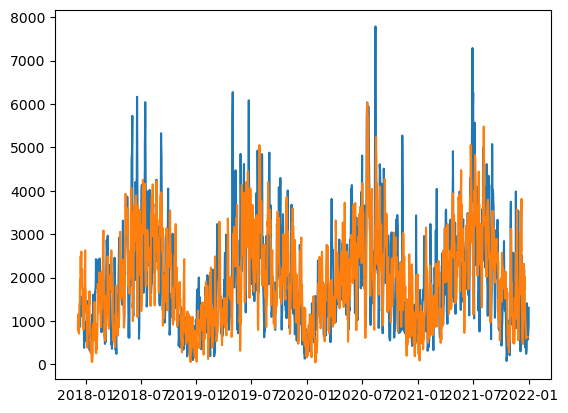

In [19]:
PRtoadm_ros_sh = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base_adm[0],factor_adm[0])
PRtoadm_rosb_sh = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtoadm_ros_m,PRtoadm_rosb_m,c,PRtoadm_ros_avg = merge(PRtoadm_ros_sh,PRtoadm_rosb_sh)
print(c)

plt.plot(PRtoadm_ros_m.Transport)
plt.plot(PRtoadm_rosb_m.Transport)

### PR to VicSill

In [20]:
PRtovs_rosl = sectransp_2018['forpr_ros3'][4]
PRtovs_rosbl = sectransp_2018['backvs_ros3'][4]

PRtovs_ros = pd.Series(PRtovs_rosl,index=datelist_vs)
PRtovs_rosb = pd.Series(PRtovs_rosbl,index=datelist_vs)

In [22]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base,factor)
        dfr2 = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.73:
            print (base, factor, corr_arr[i, j])

In [23]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.65] [0.25]


0.7294322140320535


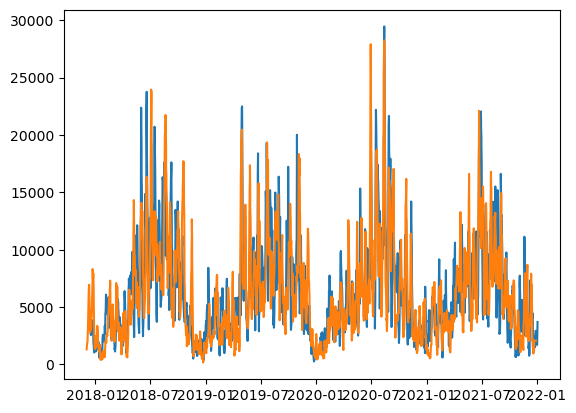

In [24]:
PRtovs_ros_sh = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base_adm[0],factor_adm[0])
PRtovs_rosb_sh = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtovs_ros_m,PRtovs_rosb_m,c,PRtovs_ros_avg = merge(PRtovs_ros_sh,PRtovs_rosb_sh)
print(c)

plt.plot(PRtovs_ros_m.Transport)
plt.plot(PRtovs_rosb_m.Transport)

0.8040834199174124


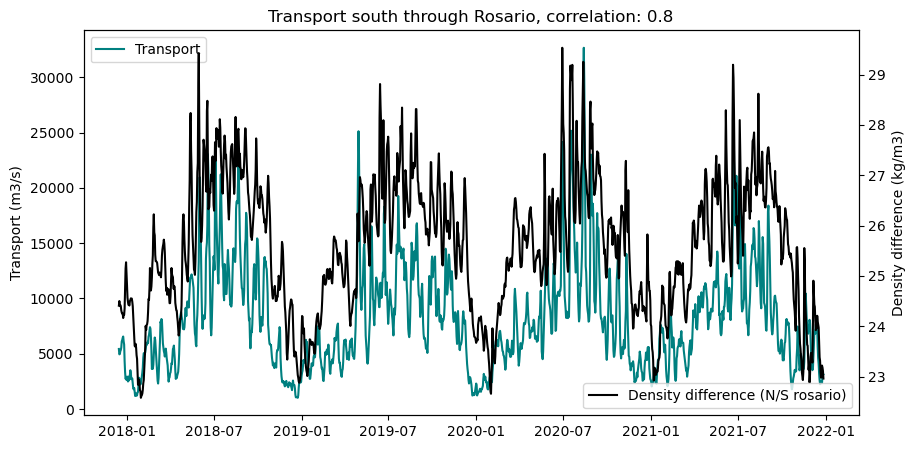

In [25]:
rostosouth = PRtovs_ros_avg + PRtoadm_ros_avg
date_rossh = list(rostosouth.dropna().index)

### Through Haro

Now need:
- PR to adm
- PR to VS
- Gulf to adm
- Gulf to VS

4 and then combine them as before

#### PR to VicSill

In [29]:
PRtovs_harol = sectransp_2018['forpr_haro3'][6]
PRtovs_harobl = sectransp_2018['backvs_haro3'][6]

PRtovs_haro = pd.Series(PRtovs_harol,index=datelist_vs)
PRtovs_harob = pd.Series(PRtovs_harobl,index=datelist_vs)

In [30]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_haro,age_2018['forpr_haro3'][6],datelist_vs,base,factor)
        dfr2 = shift_time(PRtovs_harob,age_2018['backvs_haro3'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.66:
            print (base, factor, corr_arr[i, j])

In [31]:
i_base_vs_haro,i_factor_vs_haro = np.where(corr_arr==np.max(corr_arr))

base_vs_haro = base_arr[i_base_vs_haro]
factor_vs_haro = factor_arr[i_factor_vs_haro]

print(base_vs_haro,factor_vs_haro)

[0.4] [0.15]


0.5792959700397531


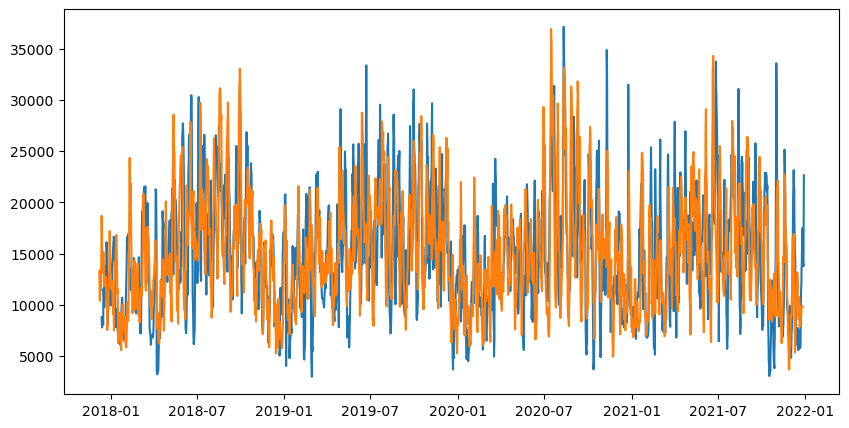

In [32]:
PRtovs_haro_sh = shift_time(PRtovs_haro,age_2018['forpr_haro3'][5],datelist_vs,base_vs_haro[0],factor_vs_haro[0])
PRtovs_harob_sh = shift_time(PRtovs_harob,age_2018['backvs_haro3'][6],datelist_vs,-base_vs_haro[0],-factor_vs_haro[0])

PRtovs_haro_m,PRtovs_harob_m,c,PRtovs_haro_avg = merge(PRtovs_haro_sh,PRtovs_harob_sh)
print(c)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(PRtovs_haro_m.Transport)
ax.plot(PRtovs_harob_m.Transport)

#### PR to adm

Negligible

These is essentially insignificant when comparing to whats going to VicSill -> ignore PR to VS

#### Gulf to VicSill

In [35]:
Gulftovs_harol = sectransp_2018['forgulf_haro3'][7]
Gulftovs_harobl = sectransp_2018['backvs_haro3'][7]

Gulftovs_haro = pd.Series(Gulftovs_harol,index=datelist_vs)
Gulftovs_harob = pd.Series(Gulftovs_harobl,index=datelist_vs)

In [36]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(Gulftovs_haro,age_2018['forgulf_haro3'][7],datelist_vs,base,factor)
        dfr2 = shift_time(Gulftovs_harob,age_2018['backvs_haro3'][7],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.69:
            print (base, factor, corr_arr[i, j])

In [37]:
i_base_gulfvs_haro,i_factor_gulfvs_haro = np.where(corr_arr==np.max(corr_arr))

base_gulfvs_haro = base_arr[i_base_gulfvs_haro]
factor_gulfvs_haro = factor_arr[i_factor_gulfvs_haro]

print(base_gulfvs_haro,factor_gulfvs_haro)

[0.95] [0.3]


0.38191112221016194


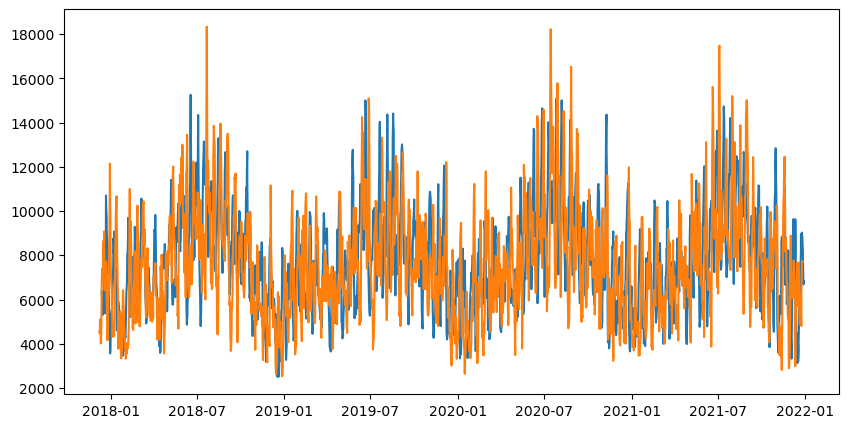

In [38]:
Gulftovs_haro_sh = shift_time(Gulftovs_haro,age_2018['forgulf_haro3'][7],datelist_vs,base_vs_haro[0],factor_vs_haro[0])
Gulftovs_harob_sh = shift_time(Gulftovs_harob,age_2018['backvs_haro3'][7],datelist_vs,-base_vs_haro[0],-factor_vs_haro[0])

Gulftovs_haro_m,Gulftovs_harob_m,c,Gulftovs_haro_avg = merge(Gulftovs_haro_sh,Gulftovs_harob_sh)
print(c)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(Gulftovs_haro_m.Transport)
ax.plot(Gulftovs_harob_m.Transport)

Gulf to VicSill more significnt than PointRob to VicSill

#### Gulf to adm

Negligible

Text(0, 0.5, 'Transport (m3/s)')

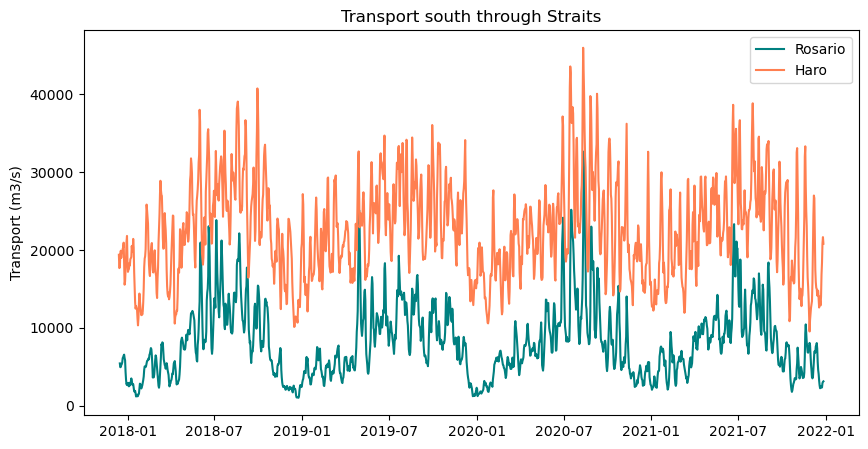

In [41]:
harotosouth = PRtovs_haro_avg + Gulftovs_haro_avg
date_harosh = list(harotosouth.dropna().index)


#### VicSill to Point Rob

In [51]:
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2021,12,20)

datelist_forvs_haro = []

while date <= enddate:
    datelist_forvs_haro.append(date)
    date+=dt.timedelta(days=1)
    
datelist_forvs_haro.pop(506)

datetime.datetime(2019, 4, 30, 0, 0)

In [53]:
VStoPR_harol = sectransp_2018['forvs_haro3'][6]
VStoPR_harobl = sectransp_2018['backpr_haro3'][6][:-8]

VStoPR_haro = pd.Series(VStoPR_harol,index=datelist_forvs_haro)
VStoPR_harob = pd.Series(VStoPR_harobl,index=datelist_vs[:-8])

In [54]:
factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoPR_haro,age_2018['forvs_haro3'][6],datelist_forvs_haro,base,factor)
        dfr2 = shift_time(VStoPR_harob,age_2018['backpr_haro3'][6],datelist_vs[:-8],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])

In [55]:
i_base_vs2pr,i_factor_vs2pr = np.where(corr_arr==np.max(corr_arr))

base_vs2pr = base_arr[i_base_vs2pr]
factor_vs2pr = factor_arr[i_factor_vs2pr]

print(base_vs2pr,factor_vs2pr)

[-0.35] [0.3]


0.7027481885452371


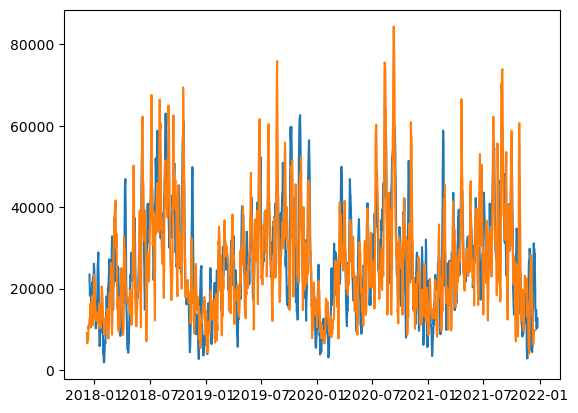

In [56]:
VStoPR_haro_sh = shift_time(VStoPR_haro,age_2018['forvs_haro3'][6],datelist_forvs_haro,base_vs2pr[0],factor_vs2pr[0])
VStoPR_harob_sh = shift_time(VStoPR_harob,age_2018['backvs_haro3'][6],datelist_vs[:-8],-base_vs2pr[0],-factor_vs2pr[0])

VStoPR_haro_m,VStoPR_harob_m,c,VStoPR_haro_avg = merge(VStoPR_haro_sh,VStoPR_harob_sh)
print(c)

plt.plot(VStoPR_haro_m.Transport)
plt.plot(VStoPR_harob_m.Transport)

#### VS to Gulf

In [57]:
VStogulf_harol = sectransp_2018['forvs_haro3'][7]
VStogulf_harobl = sectransp_2018['backgulf_haro3'][7]

VStogulf_haro = pd.Series(VStogulf_harol,index=datelist_forvs_haro)
VStogulf_harob = pd.Series(VStogulf_harobl,index=datelist_vs)

In [58]:
factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStogulf_haro,age_2018['forvs_haro3'][7],datelist_forvs_haro,base,factor)
        dfr2 = shift_time(VStogulf_harob,age_2018['backgulf_haro3'][7],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])

In [59]:
i_base_vs2gulf,i_factor_vs2gulf = np.where(corr_arr==np.max(corr_arr))

base_vs2gulf = base_arr[i_base_vs2gulf]
factor_vs2gulf = factor_arr[i_factor_vs2gulf]

print(base_vs2gulf,factor_vs2gulf)

[-0.9] [0.45]


0.7011726123289469


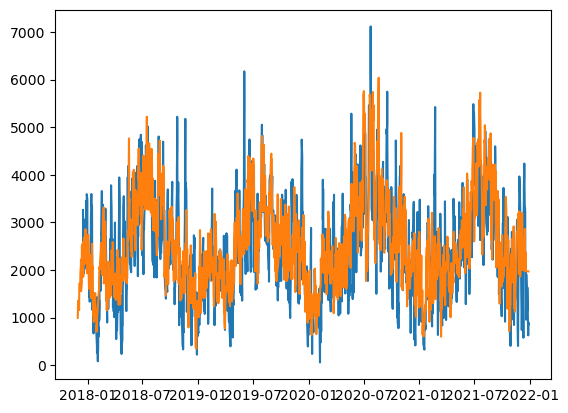

In [60]:
VStogulf_haro_sh = shift_time(VStogulf_haro,age_2018['forvs_haro3'][7],datelist_forvs_haro,base_vs2gulf[0],factor_vs2gulf[0])
VStogulf_harob_sh = shift_time(VStogulf_harob,age_2018['backgulf_haro3'][7],datelist_vs,-base_vs2gulf[0],-factor_vs2gulf[0])

VStogulf_haro_m,VStogulf_harob_m,c,VStogulf_haro_avg = merge(VStogulf_haro_sh,VStogulf_harob_sh)
print(c)

plt.plot(VStogulf_haro_m.Transport)
plt.plot(VStogulf_harob_m.Transport)

#### Adm to PR 

Negligible

#### Adm to Gulf

In [ ]:
Admtogulf_harol = sectransp_2018['foradm_haro3'][7]
Admtogulf_harobl = sectransp_2018['backgulf_haro3'][2][0:385]

Admtogulf_haro = pd.Series(Admtogulf_harol,index=datelist_vs[0:385])
Admtogulf_harob = pd.Series(Admtogulf_harobl,index=datelist_vs[0:385])

Text(0, 0.5, 'Transport (m3/s)')

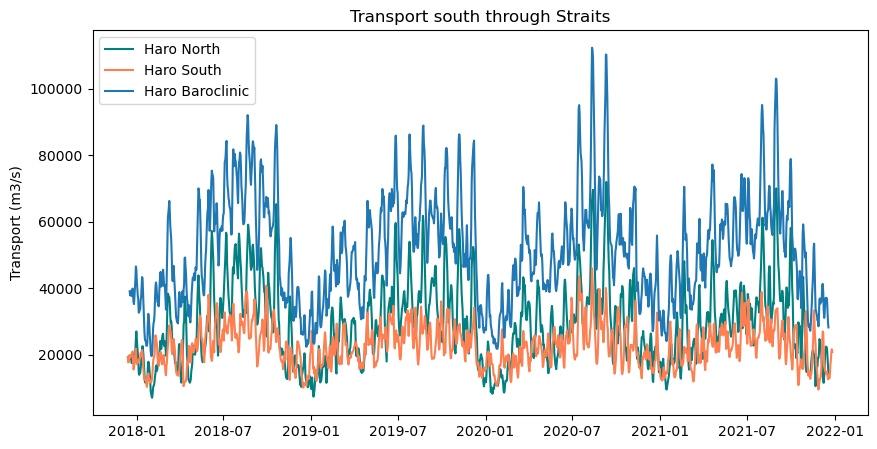

In [ ]:
harotonorth = VStogulf_haro_avg + VStoPR_haro_avg
date_haroNsh = list(harotonorth.dropna().index)
haro_bclin = (harotosouth.dropna()+harotonorth.dropna()).dropna()
date_haro_bclin = list(haro_bclin.index)

#### Correlations with baroclinic velocity

#### Shift separately each year

### Gulf to VS

#### 2018

0.8500000000000016 0.30000000000000115 0.6991381566103212
0.9000000000000017 0.30000000000000115 0.6965035292890257
0.9500000000000017 0.30000000000000115 0.6935192413846839
[0.85] [0.3]
0.46907417800157347


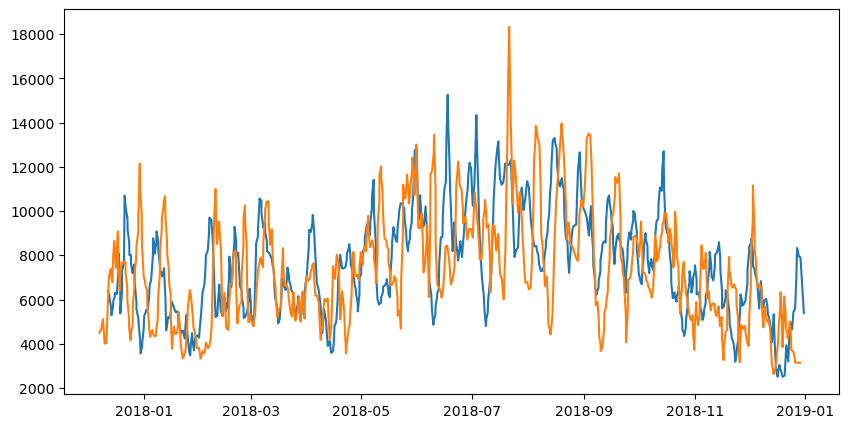

In [ ]:
Gulftovs2018_harol = sectransp_2018['forgulf_haro3'][7][0:385]
Gulftovs2018_harobl = sectransp_2018['backvs_haro3'][7][0:385]

Gulftovs2018_haro = pd.Series(Gulftovs2018_harol,index=datelist_vs[0:385])
Gulftovs2018_harob = pd.Series(Gulftovs2018_harobl,index=datelist_vs[0:385])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(Gulftovs2018_haro,age_2018['forgulf_haro3'][7][0:385],datelist_vs[0:385],base,factor)
        dfr2 = shift_time(Gulftovs2018_harob,age_2018['backvs_haro3'][7][0:385],datelist_vs[0:385],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.69:
            print (base, factor, corr_arr[i, j])
            
i_base_gulfvs_haro,i_factor_gulfvs_haro = np.where(corr_arr==np.max(corr_arr))

base_gulfvs_haro = base_arr[i_base_gulfvs_haro]
factor_gulfvs_haro = factor_arr[i_factor_gulfvs_haro]

print(base_gulfvs_haro,factor_gulfvs_haro)

Gulftovs2018_haro_sh = shift_time(Gulftovs2018_haro,age_2018['forgulf_haro3'][7][0:385],datelist_vs[0:385],base_vs_haro[0],factor_vs_haro[0])
Gulftovs2018_harob_sh = shift_time(Gulftovs2018_harob,age_2018['backvs_haro3'][7][0:385],datelist_vs[0:385],-base_vs_haro[0],-factor_vs_haro[0])

Gulftovs2018_haro_m,Gulftovs2018_harob_m,c,Gulftovs2018_haro_avg = merge(Gulftovs2018_haro_sh,Gulftovs2018_harob_sh)
print(c)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(Gulftovs2018_haro_m.Transport)
ax.plot(Gulftovs2018_harob_m.Transport)

#### 2019

[0.65] [0.35]
0.18475550411309424


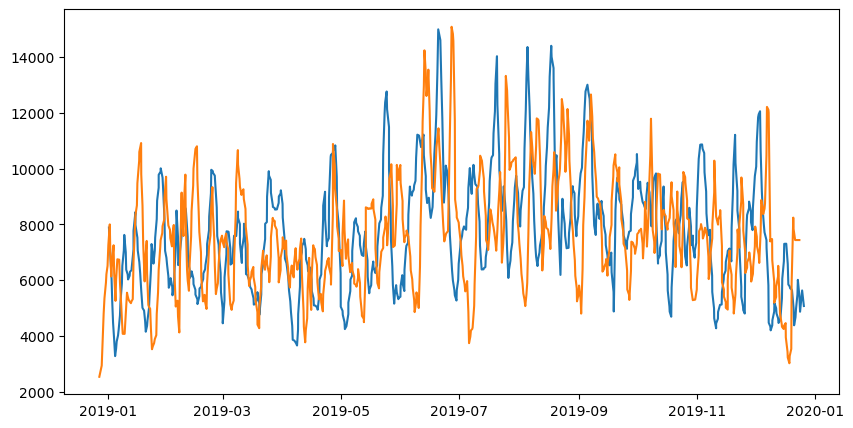

In [ ]:
Gulftovs2019_harol = sectransp_2018['forgulf_haro3'][7][385:745]
Gulftovs2019_harobl = sectransp_2018['backvs_haro3'][7][385:745]

Gulftovs2019_haro = pd.Series(Gulftovs2019_harol,index=datelist_vs[385:745])
Gulftovs2019_harob = pd.Series(Gulftovs2019_harobl,index=datelist_vs[385:745])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(Gulftovs2019_haro,age_2018['forgulf_haro3'][7][385:745],datelist_vs[385:745],base,factor)
        dfr2 = shift_time(Gulftovs2019_harob,age_2018['backvs_haro3'][7][385:745],datelist_vs[385:745],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.69:
            print (base, factor, corr_arr[i, j])
            
i_base_gulfvs_haro,i_factor_gulfvs_haro = np.where(corr_arr==np.max(corr_arr))

base_gulfvs_haro = base_arr[i_base_gulfvs_haro]
factor_gulfvs_haro = factor_arr[i_factor_gulfvs_haro]

print(base_gulfvs_haro,factor_gulfvs_haro)

Gulftovs2019_haro_sh = shift_time(Gulftovs2019_haro,age_2018['forgulf_haro3'][7][385:745],datelist_vs[385:745],base_vs_haro[0],factor_vs_haro[0])
Gulftovs2019_harob_sh = shift_time(Gulftovs2019_harob,age_2018['backvs_haro3'][7][385:745],datelist_vs[385:745],-base_vs_haro[0],-factor_vs_haro[0])

Gulftovs2019_haro_m,Gulftovs2019_harob_m,c,Gulftovs2019_haro_avg = merge(Gulftovs2019_haro_sh,Gulftovs2019_harob_sh)
print(c)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(Gulftovs2019_haro_m.Transport)
ax.plot(Gulftovs2019_harob_m.Transport)

#### 2020

[0.35] [0.35]
0.40388402434664167


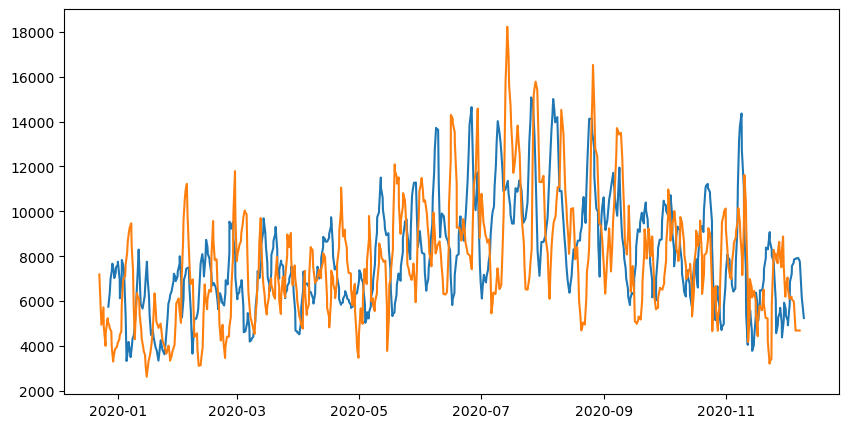

In [ ]:
Gulftovs2020_harol = sectransp_2018['forgulf_haro3'][7][745:1095]
Gulftovs2020_harobl = sectransp_2018['backvs_haro3'][7][745:1095]

Gulftovs2020_haro = pd.Series(Gulftovs2020_harol,index=datelist_vs[745:1095])
Gulftovs2020_harob = pd.Series(Gulftovs2020_harobl,index=datelist_vs[745:1095])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(Gulftovs2020_haro,age_2018['forgulf_haro3'][7][745:1095],datelist_vs[745:1095],base,factor)
        dfr2 = shift_time(Gulftovs2020_harob,age_2018['backvs_haro3'][7][745:1095],datelist_vs[745:1095],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.69:
            print (base, factor, corr_arr[i, j])
            
i_base_gulfvs_haro,i_factor_gulfvs_haro = np.where(corr_arr==np.max(corr_arr))

base_gulfvs_haro = base_arr[i_base_gulfvs_haro]
factor_gulfvs_haro = factor_arr[i_factor_gulfvs_haro]

print(base_gulfvs_haro,factor_gulfvs_haro)

Gulftovs2020_haro_sh = shift_time(Gulftovs2020_haro,age_2018['forgulf_haro3'][7][745:1095],datelist_vs[745:1095],base_vs_haro[0],factor_vs_haro[0])
Gulftovs2020_harob_sh = shift_time(Gulftovs2020_harob,age_2018['backvs_haro3'][7][745:1095],datelist_vs[745:1095],-base_vs_haro[0],-factor_vs_haro[0])

Gulftovs2020_haro_m,Gulftovs2020_harob_m,c,Gulftovs2020_haro_avg = merge(Gulftovs2020_haro_sh,Gulftovs2020_harob_sh)
print(c)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(Gulftovs2020_haro_m.Transport)
ax.plot(Gulftovs2020_harob_m.Transport)

#### 2021

[0.85] [0.3]
0.39607461497747987


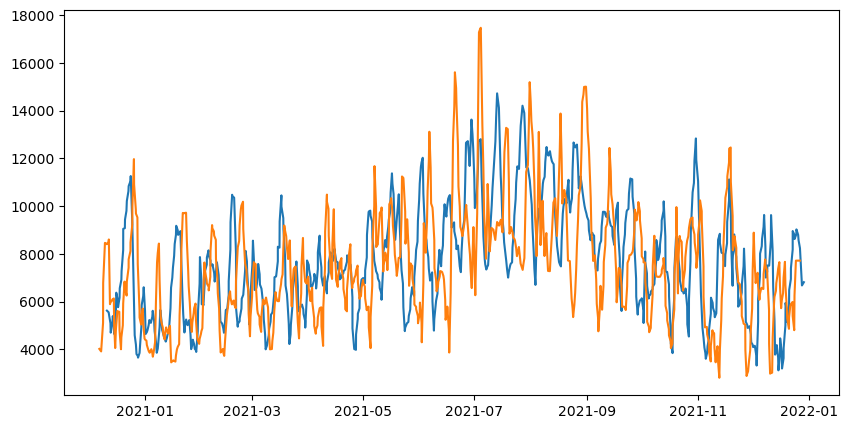

In [ ]:
Gulftovs2021_harol = sectransp_2018['forgulf_haro3'][7][1095:]
Gulftovs2021_harobl = sectransp_2018['backvs_haro3'][7][1095:]

Gulftovs2021_haro = pd.Series(Gulftovs2021_harol,index=datelist_vs[1095:])
Gulftovs2021_harob = pd.Series(Gulftovs2021_harobl,index=datelist_vs[1095:])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(Gulftovs2021_haro,age_2018['forgulf_haro3'][7][1095:],datelist_vs[1095:],base,factor)
        dfr2 = shift_time(Gulftovs2021_harob,age_2018['backvs_haro3'][7][1095:],datelist_vs[1095:],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.69:
            print (base, factor, corr_arr[i, j])
            
i_base_gulfvs_haro,i_factor_gulfvs_haro = np.where(corr_arr==np.max(corr_arr))

base_gulfvs_haro = base_arr[i_base_gulfvs_haro]
factor_gulfvs_haro = factor_arr[i_factor_gulfvs_haro]

print(base_gulfvs_haro,factor_gulfvs_haro)

Gulftovs2021_haro_sh = shift_time(Gulftovs2021_haro,age_2018['forgulf_haro3'][7][1095:],datelist_vs[1095:],base_vs_haro[0],factor_vs_haro[0])
Gulftovs2021_harob_sh = shift_time(Gulftovs2021_harob,age_2018['backvs_haro3'][7][1095:],datelist_vs[1095:],-base_vs_haro[0],-factor_vs_haro[0])

Gulftovs2021_haro_m,Gulftovs2021_harob_m,c,Gulftovs2021_haro_avg = merge(Gulftovs2021_haro_sh,Gulftovs2021_harob_sh)
print(c)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(Gulftovs2021_haro_m.Transport)
ax.plot(Gulftovs2021_harob_m.Transport)

### North flow through Haro

### VS to PR

#### 2018

0.6000000000000014 0.20000000000000107 0.7610434171755002
0.6500000000000015 0.20000000000000107 0.7604556234753509
0.7000000000000015 0.20000000000000107 0.7610134877518845
0.8500000000000016 0.20000000000000107 0.7603187637100018
0.9000000000000017 0.20000000000000107 0.7603207282678597
0.9500000000000017 0.20000000000000107 0.7648878801377903
[0.95] [0.2]
0.7302831703180953


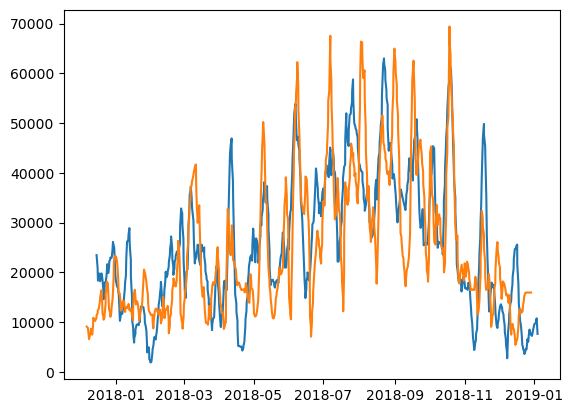

In [ ]:
VStoPR2018_harol = sectransp_2018['forvs_haro3'][6][0:385]
VStoPR2018_harobl = sectransp_2018['backpr_haro3'][6][0:385]

VStoPR2018_haro = pd.Series(VStoPR2018_harol,index=datelist_forvs_haro[0:385])
VStoPR2018_harob = pd.Series(VStoPR2018_harobl,index=datelist_vs[0:385])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoPR2018_haro,age_2018['forvs_haro3'][6][0:385],datelist_forvs_haro[0:385],base,factor)
        dfr2 = shift_time(VStoPR2018_harob,age_2018['backpr_haro3'][6][0:385],datelist_vs[0:385],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])
            
i_base_vs2pr,i_factor_vs2pr = np.where(corr_arr==np.max(corr_arr))

base_vs2pr = base_arr[i_base_vs2pr]
factor_vs2pr = factor_arr[i_factor_vs2pr]

print(base_vs2pr,factor_vs2pr)

VStoPR2018_haro_sh = shift_time(VStoPR2018_haro,age_2018['forvs_haro3'][6][0:385],datelist_forvs_haro[0:385],base_vs2pr[0],factor_vs2pr[0])
VStoPR2018_harob_sh = shift_time(VStoPR2018_harob,age_2018['backvs_haro3'][6][0:385],datelist_vs[0:385],-base_vs2pr[0],-factor_vs2pr[0])

VStoPR2018_haro_m,VStoPR2018_harob_m,c,VStoPR2018_haro_avg = merge(VStoPR2018_haro_sh,VStoPR2018_harob_sh)
print(c)

plt.plot(VStoPR2018_haro_m.Transport)
plt.plot(VStoPR2018_harob_m.Transport)

#### 2019

[0.4] [0.25]
0.7282599707391371


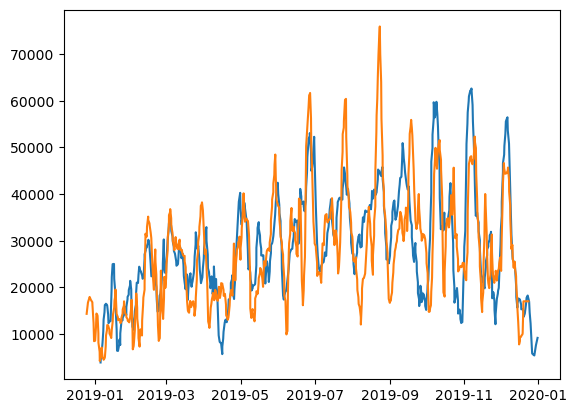

In [ ]:
VStoPR2019_harol = sectransp_2018['forvs_haro3'][6][385:745]
VStoPR2019_harobl = sectransp_2018['backpr_haro3'][6][385:745]

VStoPR2019_haro = pd.Series(VStoPR2019_harol,index=datelist_forvs_haro[385:745])
VStoPR2019_harob = pd.Series(VStoPR2019_harobl,index=datelist_vs[385:745])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoPR2019_haro,age_2018['forvs_haro3'][6][385:745],datelist_forvs_haro[385:745],base,factor)
        dfr2 = shift_time(VStoPR2019_harob,age_2018['backpr_haro3'][6][385:745],datelist_vs[385:745],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])
            
i_base_vs2pr,i_factor_vs2pr = np.where(corr_arr==np.max(corr_arr))

base_vs2pr = base_arr[i_base_vs2pr]
factor_vs2pr = factor_arr[i_factor_vs2pr]

print(base_vs2pr,factor_vs2pr)

VStoPR2019_haro_sh = shift_time(VStoPR2019_haro,age_2018['forvs_haro3'][6][385:745],datelist_forvs_haro[385:745],base_vs2pr[0],factor_vs2pr[0])
VStoPR2019_harob_sh = shift_time(VStoPR2019_harob,age_2018['backvs_haro3'][6][385:745],datelist_vs[385:745],-base_vs2pr[0],-factor_vs2pr[0])

VStoPR2019_haro_m,VStoPR2019_harob_m,c,VStoPR2019_haro_avg = merge(VStoPR2019_haro_sh,VStoPR2019_harob_sh)
print(c)

plt.plot(VStoPR2019_haro_m.Transport)
plt.plot(VStoPR2019_harob_m.Transport)

#### 2020

[-0.95] [0.35]
0.6995100361151682


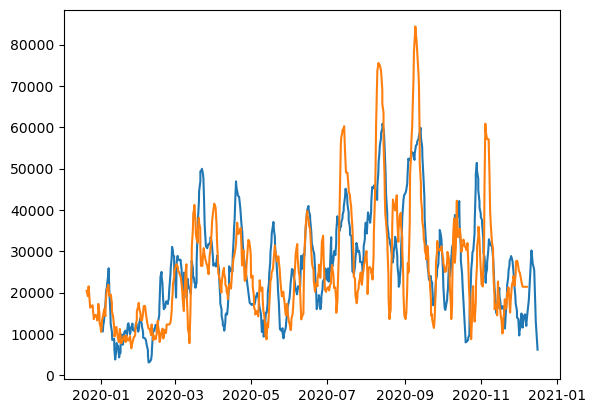

In [ ]:
VStoPR2020_harol = sectransp_2018['forvs_haro3'][6][745:1095]
VStoPR2020_harobl = sectransp_2018['backpr_haro3'][6][745:1095]

VStoPR2020_haro = pd.Series(VStoPR2020_harol,index=datelist_forvs_haro[745:1095])
VStoPR2020_harob = pd.Series(VStoPR2020_harobl,index=datelist_vs[745:1095])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoPR2020_haro,age_2018['forvs_haro3'][6][745:1095],datelist_forvs_haro[745:1095],base,factor)
        dfr2 = shift_time(VStoPR2020_harob,age_2018['backpr_haro3'][6][745:1095],datelist_vs[745:1095],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])
            
i_base_vs2pr,i_factor_vs2pr = np.where(corr_arr==np.max(corr_arr))

base_vs2pr = base_arr[i_base_vs2pr]
factor_vs2pr = factor_arr[i_factor_vs2pr]

print(base_vs2pr,factor_vs2pr)

VStoPR2020_haro_sh = shift_time(VStoPR2020_haro,age_2018['forvs_haro3'][6][745:1095],datelist_forvs_haro[745:1095],base_vs2pr[0],factor_vs2pr[0])
VStoPR2020_harob_sh = shift_time(VStoPR2020_harob,age_2018['backvs_haro3'][6][745:1095],datelist_vs[745:1095],-base_vs2pr[0],-factor_vs2pr[0])

VStoPR2020_haro_m,VStoPR2020_harob_m,c,VStoPR2020_haro_avg = merge(VStoPR2020_haro_sh,VStoPR2020_harob_sh)
print(c)

plt.plot(VStoPR2020_haro_m.Transport)
plt.plot(VStoPR2020_harob_m.Transport)

#### 2021

[-1.] [0.35]
0.6476518866623634


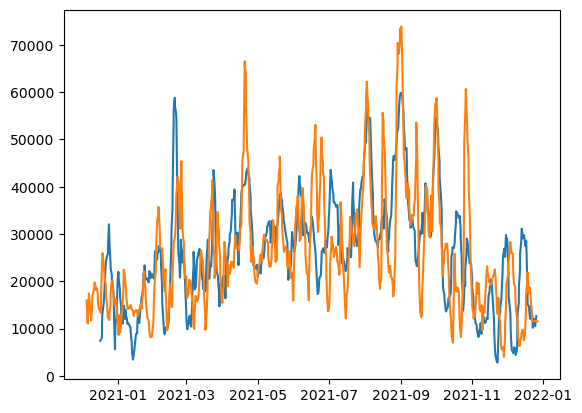

In [ ]:
VStoPR2021_harol = sectransp_2018['forvs_haro3'][6][1095:]
VStoPR2021_harobl = sectransp_2018['backpr_haro3'][6][1095:]

VStoPR2021_haro = pd.Series(VStoPR2021_harol,index=datelist_forvs_haro[1095:])
VStoPR2021_harob = pd.Series(VStoPR2021_harobl,index=datelist_vs[1095:])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoPR2021_haro,age_2018['forvs_haro3'][6][1095:],datelist_forvs_haro[1095:],base,factor)
        dfr2 = shift_time(VStoPR2021_harob,age_2018['backpr_haro3'][6][1095:],datelist_vs[1095:],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])
            
i_base_vs2pr,i_factor_vs2pr = np.where(corr_arr==np.max(corr_arr))

base_vs2pr = base_arr[i_base_vs2pr]
factor_vs2pr = factor_arr[i_factor_vs2pr]

print(base_vs2pr,factor_vs2pr)

VStoPR2021_haro_sh = shift_time(VStoPR2021_haro,age_2018['forvs_haro3'][6][1095:],datelist_forvs_haro[1095:],base_vs2pr[0],factor_vs2pr[0])
VStoPR2021_harob_sh = shift_time(VStoPR2021_harob,age_2018['backvs_haro3'][6][1095:],datelist_vs[1095:],-base_vs2pr[0],-factor_vs2pr[0])

VStoPR2021_haro_m,VStoPR2021_harob_m,c,VStoPR2021_haro_avg = merge(VStoPR2021_haro_sh,VStoPR2021_harob_sh)
print(c)

plt.plot(VStoPR2021_haro_m.Transport)
plt.plot(VStoPR2021_harob_m.Transport)

### VS to Gulf

#### 2018

[-0.05] [0.4]
0.7127408827170477


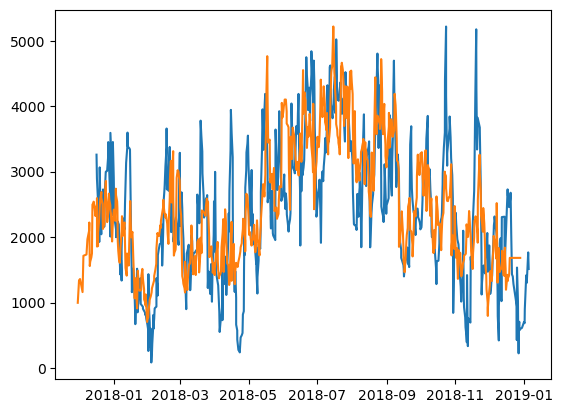

In [ ]:
VStogulf2018_harol = sectransp_2018['forvs_haro3'][7][0:385]
VStogulf2018_harobl = sectransp_2018['backgulf_haro3'][7][0:385]

VStogulf2018_haro = pd.Series(VStogulf2018_harol,index=datelist_forvs_haro[0:385])
VStogulf2018_harob = pd.Series(VStogulf2018_harobl,index=datelist_vs[0:385])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStogulf2018_haro,age_2018['forvs_haro3'][7][0:385],datelist_forvs_haro[0:385],base,factor)
        dfr2 = shift_time(VStogulf2018_harob,age_2018['backgulf_haro3'][7][0:385],datelist_vs[0:385],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])
            
i_base_vs2gulf,i_factor_vs2gulf = np.where(corr_arr==np.max(corr_arr))

base_vs2gulf = base_arr[i_base_vs2gulf]
factor_vs2gulf = factor_arr[i_factor_vs2gulf]

print(base_vs2gulf,factor_vs2gulf)

VStogulf2018_haro_sh = shift_time(VStogulf2018_haro,age_2018['forvs_haro3'][7][0:385],datelist_forvs_haro[0:385],base_vs2gulf[0],factor_vs2gulf[0])
VStogulf2018_harob_sh = shift_time(VStogulf2018_harob,age_2018['backgulf_haro3'][7][0:385],datelist_vs[0:385],-base_vs2gulf[0],-factor_vs2gulf[0])

VStogulf2018_haro_m,VStogulf2018_harob_m,c,VStogulf2018_haro_avg = merge(VStogulf2018_haro_sh,VStogulf2018_harob_sh)
print(c)

plt.plot(VStogulf2018_haro_m.Transport)
plt.plot(VStogulf2018_harob_m.Transport)

#### 2019

[0.6] [0.35]
0.6560348114070712


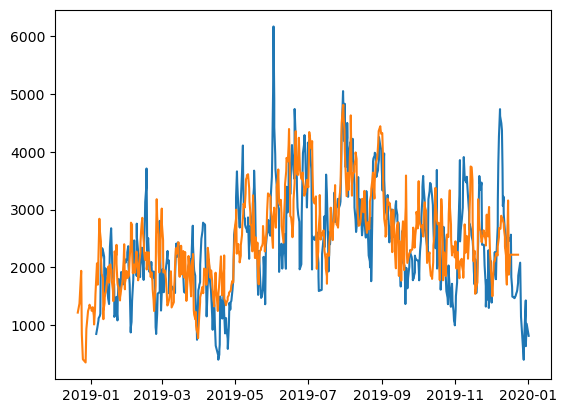

In [ ]:
VStogulf2019_harol = sectransp_2018['forvs_haro3'][7][385:745]
VStogulf2019_harobl = sectransp_2018['backgulf_haro3'][7][385:745]

VStogulf2019_haro = pd.Series(VStogulf2019_harol,index=datelist_forvs_haro[385:745])
VStogulf2019_harob = pd.Series(VStogulf2019_harobl,index=datelist_vs[385:745])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStogulf2019_haro,age_2018['forvs_haro3'][7][385:745],datelist_forvs_haro[385:745],base,factor)
        dfr2 = shift_time(VStogulf2019_harob,age_2018['backgulf_haro3'][7][385:745],datelist_vs[385:745],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])
            
i_base_vs2gulf,i_factor_vs2gulf = np.where(corr_arr==np.max(corr_arr))

base_vs2gulf = base_arr[i_base_vs2gulf]
factor_vs2gulf = factor_arr[i_factor_vs2gulf]

print(base_vs2gulf,factor_vs2gulf)

VStogulf2019_haro_sh = shift_time(VStogulf2019_haro,age_2018['forvs_haro3'][7][385:745],datelist_forvs_haro[385:745],base_vs2gulf[0],factor_vs2gulf[0])
VStogulf2019_harob_sh = shift_time(VStogulf2019_harob,age_2018['backgulf_haro3'][7][385:745],datelist_vs[385:745],-base_vs2gulf[0],-factor_vs2gulf[0])

VStogulf2019_haro_m,VStogulf2019_harob_m,c,VStogulf2019_haro_avg = merge(VStogulf2019_haro_sh,VStogulf2019_harob_sh)
print(c)

plt.plot(VStogulf2019_haro_m.Transport)
plt.plot(VStogulf2019_harob_m.Transport)

#### 2020

[0.95] [0.3]
0.7322407888933051


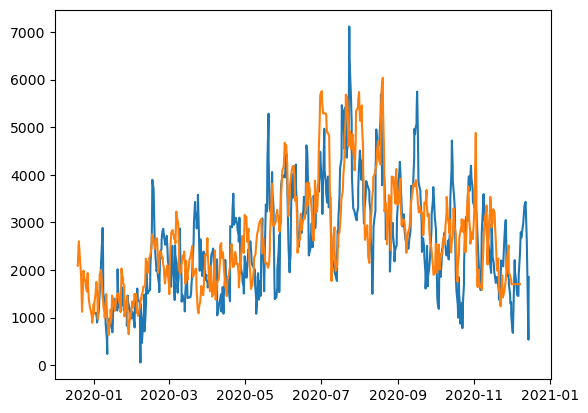

In [ ]:
VStogulf2020_harol = sectransp_2018['forvs_haro3'][7][745:1095]
VStogulf2020_harobl = sectransp_2018['backgulf_haro3'][7][745:1095]

VStogulf2020_haro = pd.Series(VStogulf2020_harol,index=datelist_forvs_haro[745:1095])
VStogulf2020_harob = pd.Series(VStogulf2020_harobl,index=datelist_vs[745:1095])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStogulf2020_haro,age_2018['forvs_haro3'][7][745:1095],datelist_forvs_haro[745:1095],base,factor)
        dfr2 = shift_time(VStogulf2020_harob,age_2018['backgulf_haro3'][7][745:1095],datelist_vs[745:1095],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])
            
i_base_vs2gulf,i_factor_vs2gulf = np.where(corr_arr==np.max(corr_arr))

base_vs2gulf = base_arr[i_base_vs2gulf]
factor_vs2gulf = factor_arr[i_factor_vs2gulf]

print(base_vs2gulf,factor_vs2gulf)

VStogulf2020_haro_sh = shift_time(VStogulf2020_haro,age_2018['forvs_haro3'][7][745:1095],datelist_forvs_haro[745:1095],base_vs2gulf[0],factor_vs2gulf[0])
VStogulf2020_harob_sh = shift_time(VStogulf2020_harob,age_2018['backgulf_haro3'][7][745:1095],datelist_vs[745:1095],-base_vs2gulf[0],-factor_vs2gulf[0])

VStogulf2020_haro_m,VStogulf2020_harob_m,c,VStogulf2020_haro_avg = merge(VStogulf2020_haro_sh,VStogulf2020_harob_sh)
print(c)

plt.plot(VStogulf2020_haro_m.Transport)
plt.plot(VStogulf2020_harob_m.Transport)

#### 2021

[-0.8] [0.4]
0.711826433023556


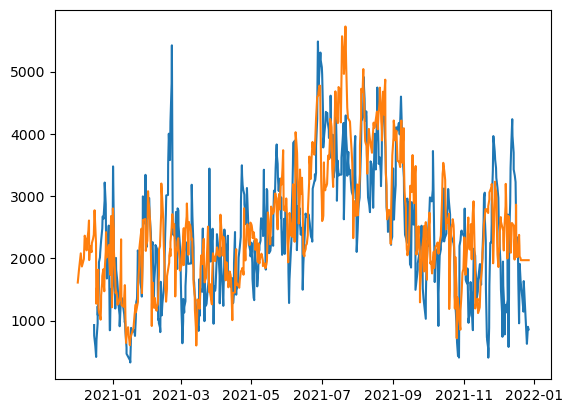

In [ ]:
VStogulf2021_harol = sectransp_2018['forvs_haro3'][7][1095:]
VStogulf2021_harobl = sectransp_2018['backgulf_haro3'][7][1095:]

VStogulf2021_haro = pd.Series(VStogulf2021_harol,index=datelist_forvs_haro[1095:])
VStogulf2021_harob = pd.Series(VStogulf2021_harobl,index=datelist_vs[1095:])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStogulf2021_haro,age_2018['forvs_haro3'][7][1095:],datelist_forvs_haro[1095:],base,factor)
        dfr2 = shift_time(VStogulf2021_harob,age_2018['backgulf_haro3'][7][1095:],datelist_vs[1095:],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])
            
i_base_vs2gulf,i_factor_vs2gulf = np.where(corr_arr==np.max(corr_arr))

base_vs2gulf = base_arr[i_base_vs2gulf]
factor_vs2gulf = factor_arr[i_factor_vs2gulf]

print(base_vs2gulf,factor_vs2gulf)

VStogulf2021_haro_sh = shift_time(VStogulf2021_haro,age_2018['forvs_haro3'][7][1095:],datelist_forvs_haro[1095:],base_vs2gulf[0],factor_vs2gulf[0])
VStogulf2021_harob_sh = shift_time(VStogulf2021_harob,age_2018['backgulf_haro3'][7][1095:],datelist_vs[1095:],-base_vs2gulf[0],-factor_vs2gulf[0])

VStogulf2021_haro_m,VStogulf2021_harob_m,c,VStogulf2021_haro_avg = merge(VStogulf2021_haro_sh,VStogulf2021_harob_sh)
print(c)

plt.plot(VStogulf2021_haro_m.Transport)
plt.plot(VStogulf2021_harob_m.Transport)

### PRtoVS

#### 2021

[0.4] [0.15]
0.55946736591343


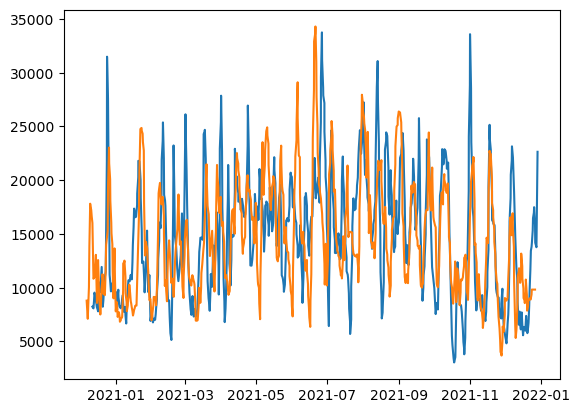

In [ ]:
PRtovs2021_harol = sectransp_2018['forpr_haro3'][6][1095:]
PRtovs2021_harobl = sectransp_2018['backvs_haro3'][6][1095:]

PRtovs2021_haro = pd.Series(PRtovs2021_harol,index=datelist_vs[1095:])
PRtovs2021_harob = pd.Series(PRtovs2021_harobl,index=datelist_vs[1095:])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2021_haro,age_2018['forpr_haro3'][6][1095:],datelist_vs[1095:],base,factor)
        dfr2 = shift_time(PRtovs2021_harob,age_2018['backvs_haro3'][6][1095:],datelist_vs[1095:],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])
            
i_base_vs2gulf,i_factor_vs2gulf = np.where(corr_arr==np.max(corr_arr))

base_vs2gulf = base_arr[i_base_vs2gulf]
factor_vs2gulf = factor_arr[i_factor_vs2gulf]

print(base_vs2gulf,factor_vs2gulf)

PRtovs2021_haro_sh = shift_time(PRtovs2021_haro,age_2018['forpr_haro3'][6][1095:],datelist_vs[1095:],base_vs2gulf[0],factor_vs2gulf[0])
PRtovs2021_harob_sh = shift_time(PRtovs2021_harob,age_2018['backvs_haro3'][6][1095:],datelist_vs[1095:],-base_vs2gulf[0],-factor_vs2gulf[0])

PRtovs2021_haro_m,PRtovs2021_harob_m,c,PRtovs2021_haro_avg = merge(PRtovs2021_haro_sh,PRtovs2021_harob_sh)
print(c)

plt.plot(PRtovs2021_haro_m.Transport)
plt.plot(PRtovs2021_harob_m.Transport)

#### VStoadm

[-0.85] [0.45]
0.3194040736656257


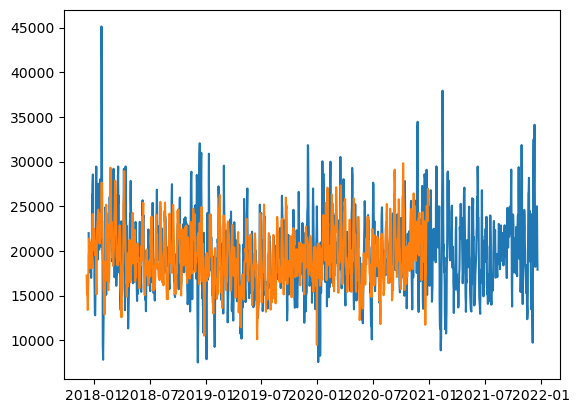

In [31]:
VStoadm_harol = sectransp_2018['forvs_haro3'][2]
VStoadm_harobl = sectransp_2018['backadm_haro3'][2]

VStoadm_haro = pd.Series(VStoadm_harol,index=datelist_vs[:8])
VStoadm_harob = pd.Series(VStoadm_harobl,index=datelist_vs[:-360])

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoadm_haro,age_2018['forvs_haro3'][2],datelist_vs[:-8],base,factor)
        dfr2 = shift_time(VStoadm_harob,age_2018['backadm_haro3'][2],datelist_vs[:-360],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])
            
i_base,i_factor = np.where(corr_arr==np.max(corr_arr))

base= base_arr[i_base]
factor = factor_arr[i_factor]

print(base,factor)

VStoadm_haro_sh = shift_time(VStoadm_haro,age_2018['forvs_haro3'][2],datelist_vs[:-8],base[0],factor[0])
VStoadm_harob_sh = shift_time(VStoadm_harob,age_2018['backadm_haro3'][2],datelist_vs[:-360],-base[0],-factor[0])

VStoadm_haro_m,VStoadm_harob_m,c,VStoadm_haro_avg = merge(VStoadm_haro_sh,VStoadm_harob_sh)
print(c)

plt.plot(VStoadm_haro_m.Transport)
plt.plot(VStoadm_harob_m.Transport)

### AdmtoVS

[0.95] [0.95]
0.3487541934270342


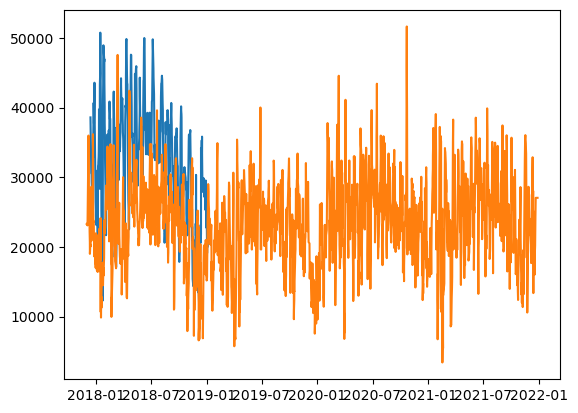

In [35]:
admtoVS_harol = sectransp_2018['foradm_haro3'][2][:385]
admtoVS_harobl = sectransp_2018['backvs_haro3'][2]

admtoVS_haro = pd.Series(admtoVS_harol,index=datelist_vs[:385])
admtoVS_harob = pd.Series(admtoVS_harobl,index=datelist_vs)

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(admtoVS_haro,age_2018['foradm_haro3'][2],datelist_vs[:385],base,factor)
        dfr2 = shift_time(admtoVS_harob,age_2018['backvs_haro3'][2],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])
            
i_base,i_factor = np.where(corr_arr==np.max(corr_arr))

base= base_arr[i_base]
factor = factor_arr[i_factor]

print(base,factor)

admtoVS_haro_sh = shift_time(admtoVS_haro,age_2018['foradm_haro3'][2],datelist_vs[:385],base[0],factor[0])
admtoVS_harob_sh = shift_time(admtoVS_harob,age_2018['backvs_haro3'][2],datelist_vs,-base[0],-factor[0])

admtoVS_haro_m,admtoVS_harob_m,c,admtoVS_haro_avg = merge(admtoVS_haro_sh,admtoVS_harob_sh)
print(c)

plt.plot(admtoVS_haro_m.Transport)
plt.plot(admtoVS_harob_m.Transport)

#### Saving files as csv

In [36]:
# Gulftovs2018_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/Gulftovs2018_haro_avg.csv',index_label='Date')
# Gulftovs2019_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/Gulftovs2019_haro_avg.csv',index_label='Date')
# Gulftovs2020_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/Gulftovs2020_haro_avg.csv',index_label='Date')
# Gulftovs2021_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/Gulftovs2021_haro_avg.csv',index_label='Date')
# Gulftovs_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/Gulftovs_haro_avg.csv',index_label='Date')
# Gulftovs_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/Gulftovs18_21_haro_avg.csv',index_label='Date')
# VStogulf2018_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStogulf2018_haro_avg.csv',index_label='Date')
# VStogulf2019_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStogulf2019_haro_avg.csv',index_label='Date')
# VStogulf2020_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStogulf2020_haro_avg.csv',index_label='Date')
# VStogulf2021_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStogulf2021_haro_avg.csv',index_label='Date')
# VStogulf_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStogulf_haro_avg.csv',index_label='Date')
# VStogulf_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStogulf18_21_haro_avg.csv',index_label='Date')
# VStoPR2018_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStoPR2018_haro_avg.csv',index_label='Date')
# VStoPR2019_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStoPR2019_haro_avg.csv',index_label='Date')
# VStoPR2020_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStoPR2020_haro_avg.csv',index_label='Date')
# VStoPR2021_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStoPR2021_haro_avg.csv',index_label='Date')
# VStoPR_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStoPR_haro_avg.csv',index_label='Date')
# VStoPR_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStoPR18_21_haro_avg.csv',index_label='Date')
# PRtovs_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs18_21_haro_avg.csv',index_label='Date')
# PRtovs2021_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtoVS2021_haro_avg.csv',index_label='Date')
# VStoadm_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStoadm_haro_avg.csv',index_label='Date')
# admtoVS_haro_avg.dropna().to_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/admtoVS_haro_avg.csv',index_label='Date')